In [ ]:
# Imports and plotting parameters

import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy
import os
import re
import random
from diff_spib import NewTimeLaggedDataset
from scipy.stats import gaussian_kde
import matplotlib as mpl
import matplotlib.colors as mcolors

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 18,
})

In [3]:
# Define utilities

class TiltGauss:
    """
    Exponentially tilted Gaussian distribution. tau=0 corresponds to the standard Gaussian.

    Used as a noise distribution in diffusion processes, sampled via
    inverse transform sampling from a precomputed CDF.

    Parameters
    ----------
    tau : float, default=1.0
        Scale factor for tilt.
    temp : float, default=1.0
        Temperature scaling of the tilt.
    device : str, default='cpu'
        Torch device for sampling.
    table_size : int, default=200000
        Number of discretization points for CDF lookup table.

    Attributes
    ----------
    r_vals : torch.Tensor
        Radii grid used for sampling.
    cdf : torch.Tensor
        Normalized cumulative distribution function for radii.
    """
    def __init__(self, tau=1.0, temp=1.0, device='cpu', table_size=200000):

        self.device = device
        self.tau = torch.tensor(tau)
        self.temp = torch.tensor(temp)

        r_max = self.tau + 10.0
        r = torch.linspace(0., r_max, table_size, device=device)
        pdf = r * torch.exp(-0.5 * (r - self.temp*self.tau)**2)
        cdf = torch.cumsum(pdf, 0)
        norm = cdf[-1].clone()
        cdf = cdf / norm

        self.r_vals = r
        self.cdf = cdf

    @torch.no_grad()
    def sample(self, n):
        """
        Sample from the tilted Gaussian distribution.

        Parameters
        ----------
        n : int
            Number of samples.

        Returns
        -------
        torch.Tensor of shape (n, 2)
            Sampled 2D vectors with tilt.
        """
        u = torch.rand(n, device=self.device)
        idx = torch.searchsorted(self.cdf, u, right=True)
        radii = self.r_vals[idx]

        dirs = torch.randn(n, 2, device=self.device)
        dirs = dirs / torch.linalg.vector_norm(dirs, dim=1, keepdim=True)
        return radii.unsqueeze(1) * dirs

def rev_sample_batch(N, custom_var, gauss_name, temp):
    """
    Reverse diffusion sampler for one batch.

    Starts from noise and iteratively applies the
    learned reverse transitions to produce samples from the data prior.

    Parameters
    ----------
    N : int
        Batch size.
    custom_var : float
        Scale applied to the initial noise samples.
    gauss_name : TiltGauss
        Sampler used to draw noise at each step.
    temp : float
        Scalar temperature used to build the temperature embedding.

    Returns
    -------
    torch.Tensor of shape (N, 2)
        Reverse-sampled batch on `IB.device`.
    """
    x = gauss_name.sample(N) * custom_var

    temp_tensor = temp*torch.ones((x.shape[0],))

    for step in range(IB.T - 1, 0, -1):

        z = torch.zeros(N, 2, device=IB.device) if step == 1 else gauss_name.sample(N) * custom_var * temp
        step_tensor = torch.full((N,), step, dtype=torch.long, device=IB.device)
        
        pred = IB.score_net(x, step_tensor, temp_tensor)
        coeff = (1 - IB.alpha_t[step]) / torch.sqrt(1 - IB.alpha_bar_t[step])
        x = (x - coeff * pred) / torch.sqrt(IB.alpha_t[step]) + torch.sqrt(IB.beta_arr[step]) * z

    return x

def kl_divergence(data_p, data_q, bins=100, epsilon=1e-10):
    """
    KL divergence D_KL(P || Q) between two 2D samples via shared 2D histograms.

    Computes 2D histogram estimates for P and Q on the same bin edges,
    adds a small epsilon for numerical stability,
    and returns the discrete KL divergence.

    Parameters
    ----------
    data_p : np.ndarray, shape (n_p, 2)
        Samples from distribution P.
    data_q : np.ndarray, shape (n_q, 2)
        Samples from distribution Q.
    bins : int or (int, int), default=100
        Number of bins per dimension (or a pair for x/y).
    epsilon : float, default=1e-10
        Small constant added to avoid log(0) and division by zero.

    Returns
    -------
    float
        Estimated KL divergence.
    """
    hist_p, x_edges, y_edges = np.histogram2d(data_p[:, 0], data_p[:, 1], bins=bins, density=True)
    hist_q, _, _ = np.histogram2d(data_q[:, 0], data_q[:, 1], bins=[x_edges, y_edges], density=True)

    p = hist_p + epsilon
    q = hist_q + epsilon
    p /= np.sum(p)
    q /= np.sum(q)
    kl_div = np.sum(p * np.log(p / q))

    return kl_div

In [19]:
# Choose experiment ("three_well" or "LJ7")

experiment = "LJ7"
model_name = f"results/{experiment}/SPIB_V0"

# Match seed with D-SPIB model

seed = 42

# Change to true for SPIB-only validation runs (see run.py)

spib_only = False

In [20]:
# Load D-SPIB object

IB = torch.load(f"{model_name}/spib_final_model.model", weights_only=False)

dt = IB.lagtime
tau = IB.tau
device = IB.device

In [21]:
# Automatically load datasets

if experiment == "LJ7":
    traj = np.load("datasets/LJ7_temperature_T=2_5_coordinate_number_trajs.npy", allow_pickle=True).item()
    traj = [v for v in traj.values()]
    label = np.loadtxt("datasets/LJ7_temperature_T=2_5_mu2_mu3_100kmeans_trajs.txt")
elif experiment == "three_well":
    traj = np.load("datasets/three_hole_potential_langevin_temperature_T=1_simulation_traj.npy")
    traj = [traj]
    label = np.load("datasets/three_hole_potential_langevin_temperature_T=1_initial_labels.npy")
    label = [label]
else:
    raise ValueError(f"Invalid experiment: {experiment}. Must be 'LJ7' or 'three_well'.")

In [22]:
# Prepare data for input

data_shape = traj[0].shape[-1]
output_dim = np.max(label) + 1
output_dim = int(output_dim)

traj_mean = np.mean(np.concatenate(traj, axis=0), axis=0); traj_std = np.std(np.concatenate(traj, axis=0), axis=0)
traj_normal = []
for i in range(len(traj)):
    traj_normal.append((traj[i] - traj_mean[None, :]) / traj_std[None, :])

past_data = []; future_data = []; labels = []; dataweight = []; temp_weight = []
for i in range(len(traj_normal)):
    past_data.append(traj_normal[i][:(len(traj_normal[i])-dt)])
    future_data.append(traj_normal[i][dt:len(traj_normal[i])])
    labels.append(label[i][dt:len(traj_normal[i])])
for i in range(len(past_data)):
    dataweight.append(np.array([1 for i in range(len(past_data[i]))]))
temp_weight.append(np.array([2/2 for i in range(len(past_data[0]))]))
if experiment == "LJ7":
    temp_weight.append(np.array([5/2 for i in range(len(past_data[1]))]))

In [23]:
# Prepare data for input

past_data = torch.from_numpy(np.concatenate(past_data, axis=0)).float().to(device) 
future_data = torch.from_numpy(np.concatenate(future_data, axis=0)).float().to(device)
labels = torch.from_numpy(np.concatenate(labels, axis=0)).to(device) 
dataweight = torch.from_numpy(np.concatenate(dataweight)).float().to(device)
temp_weight = torch.from_numpy(np.concatenate(temp_weight)).float().to(device)
label_data = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=torch.max(labels.to(torch.int64)+1)).long().to(device)

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

indices = list(range(len(past_data)))
split = int(np.floor(0.2 * len(past_data)))
valid_split = int(np.floor(0.8 * len(past_data)))
np.random.shuffle(indices)
train_indices, test_indices, valid_indices = indices[split:valid_split], indices[:split], indices[valid_split:]
train_dataset = NewTimeLaggedDataset(past_data[train_indices], future_data[train_indices], label_data[train_indices], dataweight[train_indices], temp_weight[train_indices])
test_dataset = NewTimeLaggedDataset(past_data[test_indices], future_data[test_indices], label_data[test_indices], dataweight[test_indices], temp_weight[test_indices])

valid_indices_path = os.path.join(model_name, "spib_valid_indices.npy")
valid_indices_loaded = np.load(valid_indices_path).tolist()

if valid_indices_loaded != valid_indices:
    raise ValueError("Error with validation set.")

In [24]:
# For SPIB-only validation runs, sample from VampPrior using learned pseudo-inputs

if spib_only:

    if experiment == "three_well":
        N = 1000000
    else:
        N = 200000

    representative_z_mean, representative_z_logvar = IB.encode(IB.representative_inputs)
    representative_z_mean = representative_z_mean.detach().numpy()
    representative_z_var = np.exp(representative_z_logvar.detach().numpy())

    with open(f"{model_name}/spib_d=2_t={dt}_b=0.0000_learn=0.001000_train.log", "r") as f:
        lines = f.readlines()

    for line in reversed(lines):
        match = re.search(r"\[([^\]]+)\]", line)
        if match:
            arr = np.fromstring(match.group(1), sep=" ")
            break

    weight = arr

    vamp_samples = []
    for i in range(len(weight)):
        _samples = np.random.multivariate_normal(representative_z_mean[i], np.sqrt(representative_z_var)*np.identity(2), size=int(N*weight[i]))
        vamp_samples.append(_samples)
    
    vamp_samples = np.concatenate(vamp_samples, axis=0)
    gen_samples_T2 = torch.tensor(vamp_samples)

In [25]:
# Load validation trajectories

valid_traj = past_data[valid_indices]
valid_temp = temp_weight[valid_indices]

mask_T2 = valid_temp == 1.0
valid_traj_T2 = valid_traj[mask_T2]
labels_T2, prediction_T2, z_latent_T2, _ = IB.transform(valid_traj_T2, batch_size=512, to_numpy=True)

if experiment == "LJ7" and spib_only == False:
    mask_T5 = valid_temp == 2.5
    valid_traj_T5 = valid_traj[mask_T5]
    labels_T5, prediction_T5, z_latent_T5, _ = IB.transform(valid_traj_T5, batch_size=512, to_numpy=True)

In [26]:
# Define tilted Gaussian objects for sampling

tilt_gauss_2 = TiltGauss(tau, 2.0/2.0, device)
if experiment == "LJ7":
    tilt_gauss_5 = TiltGauss(tau, 5.0/2.0, device)

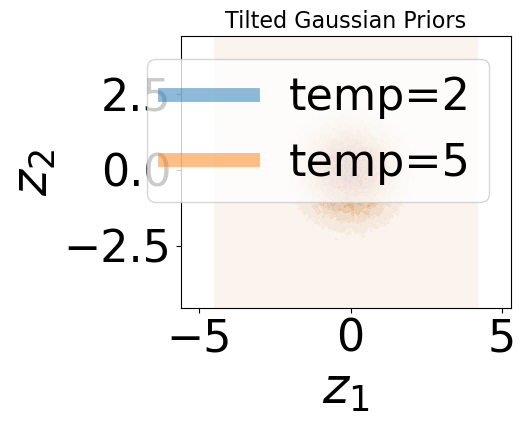

In [27]:
# Show Gaussian priors with temperature scaled variance

if experiment == "LJ7" and spib_only == False:

    sample_2 = tilt_gauss_2.sample(100000) * IB.custom_var
    sample_5 = tilt_gauss_5.sample(100000) * IB.custom_var

    bins = 100

    x_min = min(sample_2[:, 0].min(), sample_5[:, 0].min())
    x_max = max(sample_2[:, 0].max(), sample_5[:, 0].max())
    y_min = min(sample_2[:, 1].min(), sample_5[:, 1].min())
    y_max = max(sample_2[:, 1].max(), sample_5[:, 1].max())

    xedges = np.linspace(x_min, x_max, bins + 1)
    yedges = np.linspace(y_min, y_max, bins + 1)

    H2, _, _ = np.histogram2d(sample_2[:, 0], sample_2[:, 1],
                          bins=[xedges, yedges], density=True)
    H5, _, _ = np.histogram2d(sample_5[:, 0], sample_5[:, 1],
                          bins=[xedges, yedges], density=True)

    Xc = 0.5 * (xedges[:-1] + xedges[1:])
    Yc = 0.5 * (yedges[:-1] + yedges[1:])
    X, Y = np.meshgrid(Xc, Yc)

    fig, ax = plt.subplots(figsize=(6, 5))

    ax.contourf(X, Y, H2.T, levels=10, cmap='Blues', alpha=0.5)
    ax.contourf(X, Y, H5.T, levels=10, cmap='Oranges', alpha=0.5)

    ax.set_xlabel(r"$z_1$")
    ax.set_ylabel(r"$z_2$")
    ax.set_title('Tilted Gaussian Priors')
    ax.axis('equal')

    handles = [plt.Line2D([], [], lw=10, color='tab:blue',   alpha=0.5, label='temp=2'),
           plt.Line2D([], [], lw=10, color='tab:orange', alpha=0.5, label='temp=5')]
    ax.legend(handles=handles, loc='upper right')

    plt.tight_layout()
    plt.show()

In [28]:
# Generate data by reversing the diffusion process

if spib_only == False:

    if experiment == "three_well":
        N = 1000000
    else:
        N = 200000

    batch_size = 5000
    custom_var = IB.custom_var

    gen_samples_T2 = torch.empty(N, 2)
    with torch.no_grad():
        for i in range(0, N, batch_size):
            n = min(batch_size, N - i)
            batch = rev_sample_batch(n, custom_var, tilt_gauss_2, 2/2).cpu()
            gen_samples_T2[i:i+n] = batch
            del batch
            
    if experiment == "LJ7":
        gen_samples_T5 = torch.empty(N, 2)
        with torch.no_grad():
            for i in range(0, N, batch_size):
                n = min(batch_size, N - i)
                batch = rev_sample_batch(n, custom_var, tilt_gauss_5, 5/2).cpu()
                gen_samples_T5[i:i+n] = batch
                del batch

gen_samples_T2 = gen_samples_T2.cpu().detach().numpy()

if experiment == "LJ7" and spib_only == False:
    gen_samples_T5 = gen_samples_T5.cpu().detach().numpy()

In [30]:
# Plot two-dimensional free energy surface for the three-well experiment

if experiment == "three_well":

    mpl.rcParams.update({
        "font.size": 32,
        "axes.labelsize": 36,
        "xtick.labelsize": 32,
        "ytick.labelsize": 32,
        "legend.fontsize": 32
    })

    bins = 100

    x_min = min(z_latent_T2[:, 0].min(), gen_samples_T2[:, 0].min())
    x_max = max(z_latent_T2[:, 0].max(), gen_samples_T2[:, 0].max())
    y_min = min(z_latent_T2[:, 1].min(), gen_samples_T2[:, 1].min())
    y_max = max(z_latent_T2[:, 1].max(), gen_samples_T2[:, 1].max())

    xedges = np.linspace(x_min, x_max, bins + 1)
    yedges = np.linspace(y_min, y_max, bins + 1)

    H1, _, _ = np.histogram2d(z_latent_T2[:, 0], z_latent_T2[:, 1], bins=[xedges, yedges])
    H2, _, _ = np.histogram2d(gen_samples_T2[:, 0], gen_samples_T2[:, 1], bins=[xedges, yedges])

    H1[H1 < 1] = np.nan
    H2[H2 < 1] = np.nan
    FE1 = -np.log(H1)
    FE1 -= np.nanmin(FE1)
    FE2 = -np.log(H2)
    FE2 -= np.nanmin(FE2)

    _x = 0.5 * (xedges[:-1] + xedges[1:])
    _y = 0.5 * (yedges[:-1] + yedges[1:])

    fig, axes = plt.subplots(1, 2, figsize=(20, 9), sharex=True, sharey=True, constrained_layout=True)
    levels = 10
    vmin, vmax = 0.1, 6
    cmap = 'viridis_r'

    cf1 = axes[0].contourf(_x, _y, FE1.T, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.9)
    axes[0].contour(_x, _y, FE1.T, levels=levels, colors='black', vmin=vmin, vmax=vmax)
    axes[0].set_title("Encoded Data", fontsize=40)
    axes[0].set_xlabel(r"$z_{1}$")
    axes[0].set_ylabel(r"$z_{2}$")

    cf2 = axes[1].contourf(_x, _y, FE2.T, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.9)
    axes[1].contour(_x, _y, FE2.T, levels=levels, colors='black', vmin=vmin, vmax=vmax)
    axes[1].set_title("Generated Data", fontsize=40)
    axes[1].set_xlabel(r"$z_{1}$")

    for ax in axes:
        ax.set_xlim(-8, 8)
        ax.set_ylim(-8, 8)

    cbar = fig.colorbar(cf1, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label(r"Free Energy $(k_BT)$")

    plt.show()

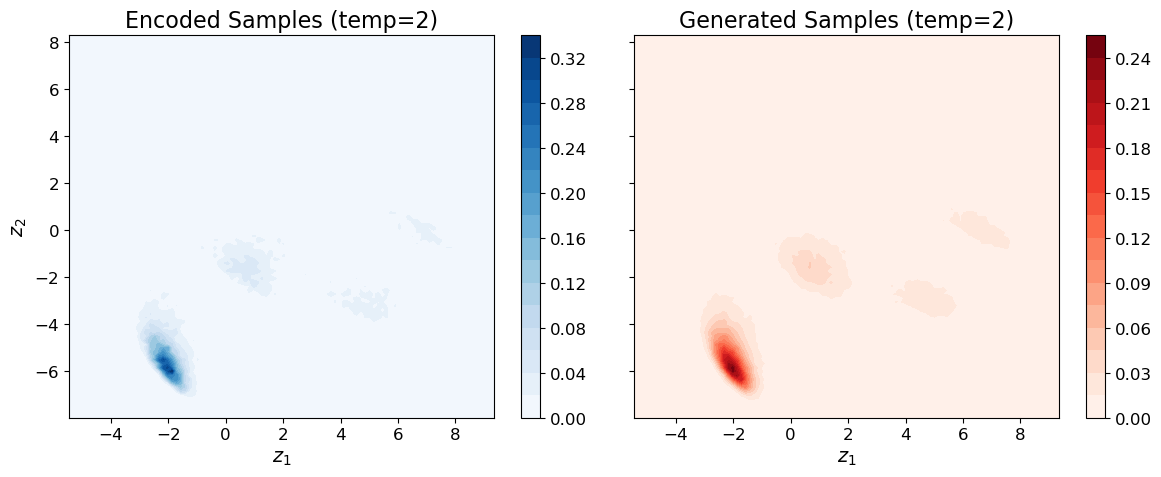

In [31]:
# Plot temperature=0.2 encoded vs. generated densities (corresponds to the single-temperature three_well experiment)

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 18,
})

bins = 100

x_min = min(z_latent_T2[:, 0].min(), gen_samples_T2[:, 0].min())
x_max = max(z_latent_T2[:, 0].max(), gen_samples_T2[:, 0].max())
y_min = min(z_latent_T2[:, 1].min(), gen_samples_T2[:, 1].min())
y_max = max(z_latent_T2[:, 1].max(), gen_samples_T2[:, 1].max())

xedges = np.linspace(x_min, x_max, bins + 1)
yedges = np.linspace(y_min, y_max, bins + 1)

H1, _, _ = np.histogram2d(z_latent_T2[:, 0], z_latent_T2[:, 1], bins=[xedges, yedges], density=True)
H2, _, _ = np.histogram2d(gen_samples_T2[:, 0], gen_samples_T2[:, 1], bins=[xedges, yedges], density=True)

X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

c1 = axes[0].contourf(X, Y, H1.T, levels=20, cmap='Blues')
axes[0].set_title("Encoded Samples (temp=0.2)")
axes[0].set_xlabel("$z_1$")
axes[0].set_ylabel("$z_2$")
fig.colorbar(c1, ax=axes[0])

c2 = axes[1].contourf(X, Y, H2.T, levels=20, cmap='Reds')
axes[1].set_title("Generated Samples (temp=0.2)")
axes[1].set_xlabel("$z_1$")
fig.colorbar(c2, ax=axes[1])

plt.tight_layout()
plt.show()

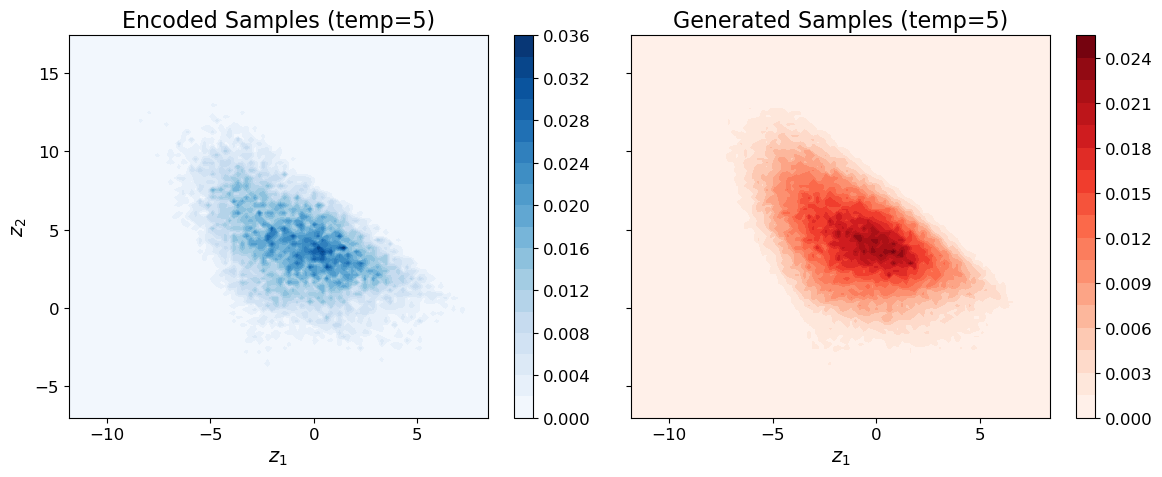

In [32]:
# Plot temperature=0.5 encoded vs. generated densities (only for LJ7 experiment)

if experiment == "LJ7" and spib_only == False:

    bins = 100

    x_min = min(z_latent_T5[:, 0].min(), gen_samples_T5[:, 0].min())
    x_max = max(z_latent_T5[:, 0].max(), gen_samples_T5[:, 0].max())
    y_min = min(z_latent_T5[:, 1].min(), gen_samples_T5[:, 1].min())
    y_max = max(z_latent_T5[:, 1].max(), gen_samples_T5[:, 1].max())

    xedges = np.linspace(x_min, x_max, bins + 1)
    yedges = np.linspace(y_min, y_max, bins + 1)

    H1, _, _ = np.histogram2d(z_latent_T5[:, 0], z_latent_T5[:, 1], bins=[xedges, yedges], density=True)
    H2, _, _ = np.histogram2d(gen_samples_T5[:, 0], gen_samples_T5[:, 1], bins=[xedges, yedges], density=True)

    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    c1 = axes[0].contourf(X, Y, H1.T, levels=20, cmap='Blues')
    axes[0].set_title("Encoded Samples (temp=0.5)")
    axes[0].set_xlabel("$z_1$")
    axes[0].set_ylabel("$z_2$")
    fig.colorbar(c1, ax=axes[0])

    c2 = axes[1].contourf(X, Y, H2.T, levels=20, cmap='Reds')
    axes[1].set_title("Generated Samples (temp=0.5)")
    axes[1].set_xlabel("$z_1$")
    fig.colorbar(c2, ax=axes[1])

    plt.tight_layout()
    plt.show()

In [33]:
# Compute symmetrized KL divergences for either experiment

kl_2 = (kl_divergence(z_latent_T2, gen_samples_T2) + kl_divergence(gen_samples_T2, z_latent_T2))/2
print('KL divergence for temperature = 2: ', kl_2)

if experiment == "LJ7" and spib_only == False:
    kl_5 = (kl_divergence(z_latent_T5, gen_samples_T5) + kl_divergence(gen_samples_T5, z_latent_T5))/2
    print('KL divergence for temperature = 5: ', kl_5)

KL divergence for temperature = 2:  0.5372730079287322
KL divergence for temperature = 5:  0.3897099871912334


In [34]:
# Generate samples for multi-temperature extrapolation test (LJ7 only)

if experiment == "LJ7" and spib_only == False:

    tilt_gauss_3 = TiltGauss(tau, 3.0/2.0, device)
    tilt_gauss_4 = TiltGauss(tau, 4.0/2.0, device)
    tilt_gauss_6 = TiltGauss(tau, 6.0/2.0, device)
    tilt_gauss_7 = TiltGauss(tau, 7.0/2.0, device)

    num_samples = 20000

    N = num_samples
    batch_size = 5000
    gen_samples_T2 = torch.empty(N, 2)
    gen_samples_T3 = torch.empty(N, 2)
    gen_samples_T4 = torch.empty(N, 2)
    gen_samples_T5 = torch.empty(N, 2)
    gen_samples_T6 = torch.empty(N, 2)
    gen_samples_T7 = torch.empty(N, 2)
    custom_var = IB.custom_var

    with torch.no_grad():
        for i in range(0, N, batch_size):
            n = min(batch_size, N - i)
            batch = rev_sample_batch(n, custom_var, tilt_gauss_2, 1.0).cpu()
            gen_samples_T2[i:i+n] = batch
            del batch

    with torch.no_grad():
        for i in range(0, N, batch_size):
            n = min(batch_size, N - i)
            batch = rev_sample_batch(n, custom_var, tilt_gauss_3, 1.5).cpu()
            gen_samples_T3[i:i+n] = batch
            del batch

    with torch.no_grad():
        for i in range(0, N, batch_size):
            n = min(batch_size, N - i)
            batch = rev_sample_batch(n, custom_var, tilt_gauss_4, 2.0).cpu()
            gen_samples_T4[i:i+n] = batch
            del batch

    with torch.no_grad():
        for i in range(0, N, batch_size):
            n = min(batch_size, N - i)
            batch = rev_sample_batch(n, custom_var, tilt_gauss_5, 2.5).cpu()
            gen_samples_T5[i:i+n] = batch
            del batch

    with torch.no_grad():
        for i in range(0, N, batch_size):
            n = min(batch_size, N - i)
            batch = rev_sample_batch(n, custom_var, tilt_gauss_6, 3.0).cpu()
            gen_samples_T6[i:i+n] = batch
            del batch

    with torch.no_grad():
        for i in range(0, N, batch_size):
            n = min(batch_size, N - i)
            batch = rev_sample_batch(n, custom_var, tilt_gauss_7, 3.5).cpu()
            gen_samples_T7[i:i+n] = batch
            del batch

In [35]:
# Load MD data for comparison on the LJ7 multi-temperature extrapolation test

if experiment == "LJ7" and spib_only == False:

    generate_samples = {}
    generate_samples[2] = gen_samples_T2
    generate_samples[3] = gen_samples_T3
    generate_samples[4] = gen_samples_T4
    generate_samples[5] = gen_samples_T5
    generate_samples[6] = gen_samples_T6
    generate_samples[7] = gen_samples_T7

    md_data = np.load('./datasets/LJ7_all_temperatures_sparse_trajs.npy', allow_pickle=True).item()
    md_data = [(v- traj_mean[None, :])/traj_std[None, :] for v in md_data.values()]
    md_ref = []
    for i in range(len(md_data)):
        _, _, _p, _ = IB.transform(torch.from_numpy(md_data[i]).float(), batch_size=512, to_numpy=True)
        md_ref.append(_p)

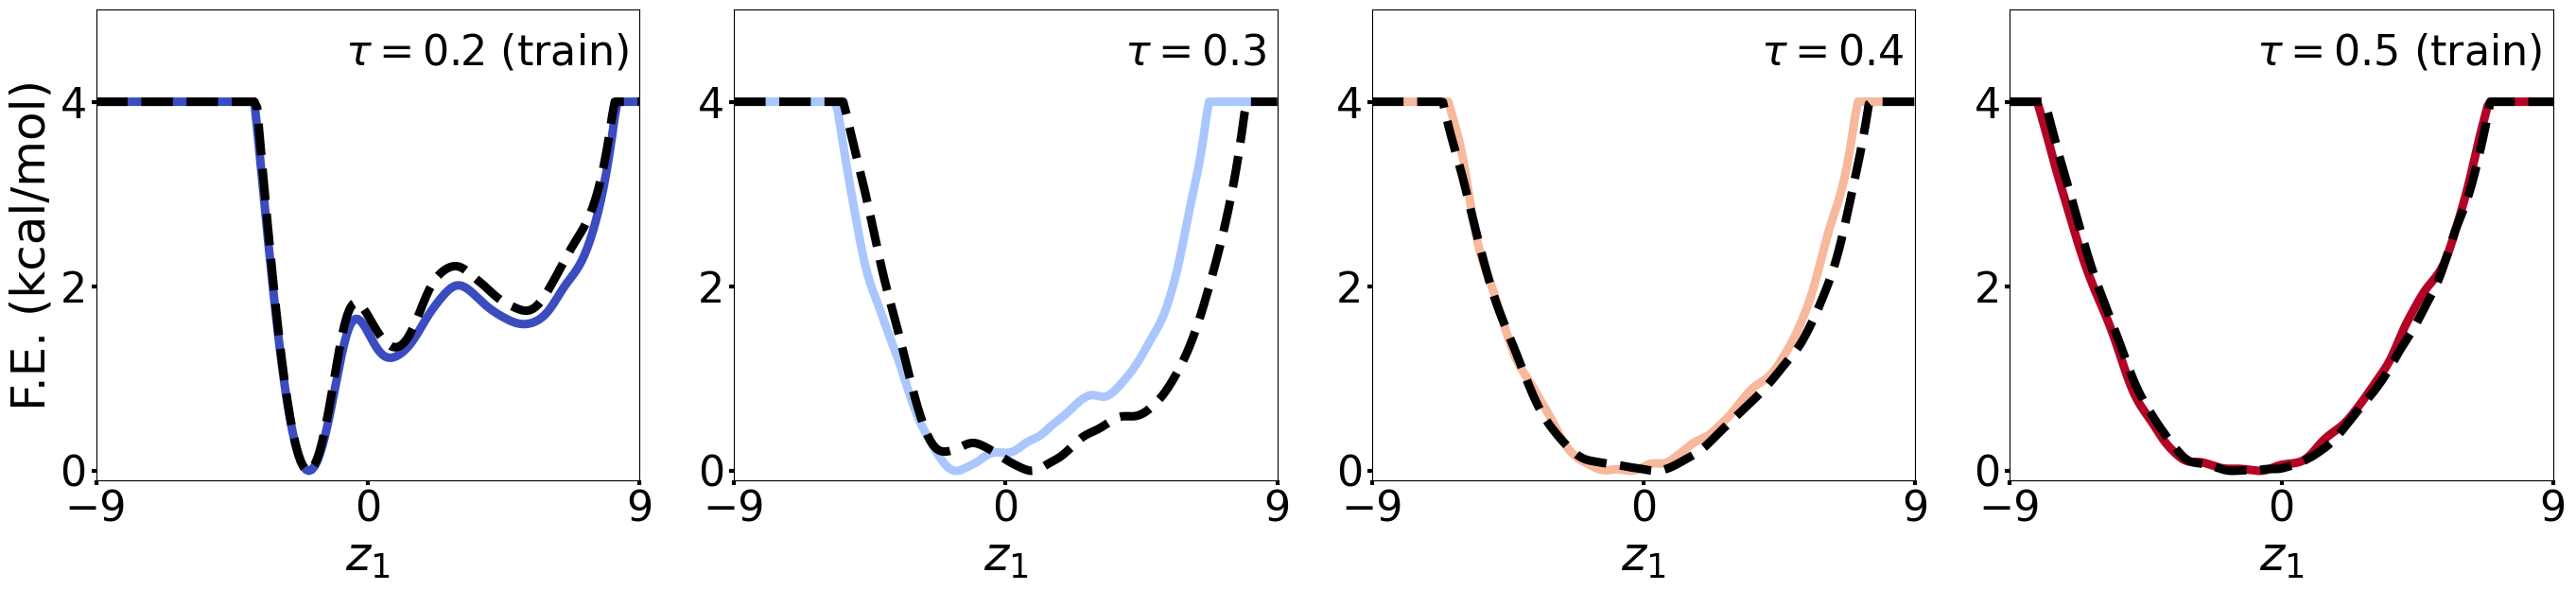

In [36]:
# Make multi-temperature LJ7 plots

if experiment == "LJ7" and spib_only == False:
    
    mpl.rcParams.update({
        "font.size": 32,
        "axes.labelsize": 36,
        "xtick.labelsize": 32,
         "ytick.labelsize": 32,
        "legend.fontsize": 32
    })

    cmap = mpl.cm.coolwarm
    norm = mcolors.Normalize(vmin=2, vmax=7)
    values = np.linspace(2, 7, 4)
    colors = cmap(norm(values))

    selected_indices = [0, 1, 2, 3]
    selected_temps   = [2, 3, 4, 5]

    tau_labels = [
        r"$\tau = 0.2$ (train)",
        r"$\tau = 0.3$",
        r"$\tau = 0.4$",
        r"$\tau = 0.5$ (train)"
    ]

    fig, ax = plt.subplots(1, 4, figsize=(28, 7))

    for plot_idx, i in enumerate(selected_indices):
        temp = selected_temps[plot_idx]

        sample_kde = gaussian_kde(generate_samples[temp][:, 0], bw_method=0.1)
        sample_grid = np.linspace(-9, 9, 200)
        sample_x = sample_kde(sample_grid)
        sample_fe = -np.log(sample_x + 1e-7)
        sample_fe -= np.min(sample_fe)
        sample_fe[sample_fe > 4.0] = 4.0

        md_kde = gaussian_kde(md_ref[i][:, 0], bw_method=0.1)
        md_grid = np.linspace(-9, 9, 200)
        md_x = md_kde(md_grid)
        md_fe = -np.log(md_x + 1e-7)
        md_fe -= np.min(md_fe)
        md_fe[md_fe > 4.0] = 4.0

        ax[plot_idx].plot(sample_grid, sample_fe, linewidth=6.5, color=colors[i])
        ax[plot_idx].plot(md_grid, md_fe, linewidth=6.5, color='black', linestyle='--')
        ax[plot_idx].set_xlabel(r"$z_{1}$")

        if plot_idx == 0:
            ax[plot_idx].set_ylabel("F.E. (kcal/mol)")
        else:
            ax[plot_idx].set_ylabel("")

        ax[plot_idx].set_xlim(-9, 9)
        ax[plot_idx].set_xticks(np.arange(-9, 10, 9))
        ax[plot_idx].set_ylim(-0.1, 5.0)
        ax[plot_idx].set_yticks(np.arange(0, 5.1, 2))

        ax[plot_idx].tick_params(axis='both', which='major', width=3)

        ax[plot_idx].text(
            0.98, 0.95, tau_labels[plot_idx],
            transform=ax[plot_idx].transAxes,
            ha='right', va='top'
        )

    plt.tight_layout()
    plt.show()